In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Polynomial interactions
In this notebook, we consider the an Ising model of 
the form
 
$$ H[x] = \sum_{i,j} A_{i,j} x_i x_j + \sum_{i,j} B_{i,j,k} x_i x_j x_k $$

where $A$ and $B$ denote a symmetric 2-tensor and a 
symmetric 3-tensor (respectively), and $x\in \{-1,1\}^N$ is a Ising 
vector.
The energy function of this Ising model is 

$$ p(x) = \frac{1}{Z} \operatorname{exp}(-H[x])$$

where $Z$ is a normalizing constant.


# Density class:
We represent this density using a class 

```density_obj = PMF(A: np.ndarray, B: np.ndarray)```
where `A` and `B` are `np.ndarray`'s of shape `(N, N)` and 
`(N, N, N)` respectively.


In [2]:
from src.polynomial_interactions_util import PMF
N = 3
A = np.random.randn(N, N)
B = np.random.randn(N, N, N)
density_obj = PMF(A, B)


Instances of this class carry methods:
1. `density_obj.pmf(x: np.ndarray)` which computes the probability
mass function at a given batch of Ising variables. 
2. `density_obj.sample_exactly(shape: Tuple)` which returns samples of
shape `(*shape, N)` from the Ising model. 
2. `density_obj.sample_Metropolis_Hastings(shape: Tuple)` which returns 
approximate samples of shape `(*shape, N)` from the Ising model; where
the approximate samples are computed using the Metropolis-Hastings algorithm.



# Convergence of exact sampling:

We sample exactly from the pmf, and graph the convergence (in l2 norm) 
of the empirical distribution to the analytical distribution:


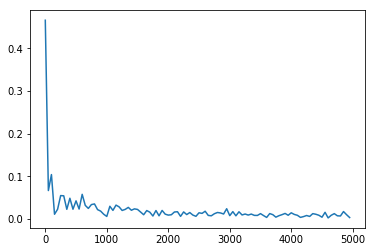

In [3]:
from src.tests.utils import estimate_empirical_distance_for_instance
sample_sizes = list(range(1, 5000, 50))
# Estimate the l2 distance between the empirical pmf
# and the analytic pmf:
# (Note that distances are sampled independently).
l2_dists = [
    estimate_empirical_distance_for_instance(
        density_object=density_obj,
        num_samples=n,
        sampler=PMF.sample_exactly
    )
    for n in sample_sizes
]
plt.plot(sample_sizes, l2_dists)
plt.show()




# Convergence of MCMC sampling:

We use the Metropolis-Hastings algorithm to approximately sample 
from the pmf, and graph the convergence (in l2 norm) 
of the empirical distribution to the analytical distribution:


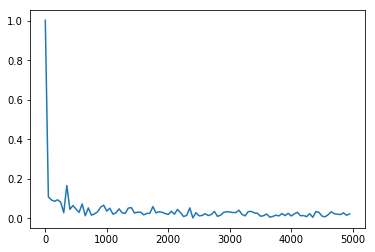

In [4]:
from src.tests.utils import estimate_empirical_distance_for_instance
# Estimate the l2 distance between the empirical pmf
# and the analytic pmf:
l2_dists = [
    estimate_empirical_distance_for_instance(
        density_object=density_obj,
        num_samples=n,
        sampler=PMF.sample_Metropolis_Hastings
    )
    for n in sample_sizes
]
plt.plot(sample_sizes, l2_dists)
plt.show()


Note that MCMC algorithm yields an empirical distribution which converges more
slowly to the analytic distribution than `sample_exactly`.


# Pairwise convergence of the sampling algorithms

We now check that the empirical probability mass functions of the
two sampling algorithms converge:


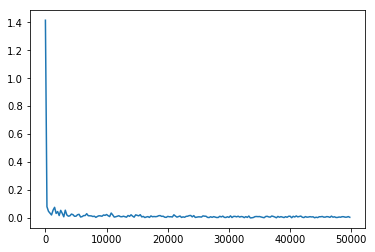

In [5]:
from src.pmf_utils import compute_empirical_pmf, l2_distance_between_pmfs
sample_sizes = list(range(1, 50000, 250))
# Compute the empirical pmfs for the exact sampler:
# (Note that these are sampled independently).
exactly_sampled_pmfs = [
    compute_empirical_pmf(
        density_obj.sample_exactly((n,))
    )
    for n in sample_sizes
]
# Compute the empirical pmfs for the approximate mcmc sampler:
mcmc_sampled_pmfs = [
    compute_empirical_pmf(
        density_obj.sample_Metropolis_Hastings((n,))
    )
    for n in sample_sizes
]
# Compute the l2 distances between the pmfs:
all_states = density_obj.all_states() 
l2_dists = [
    l2_distance_between_pmfs(all_states, pmf1, pmf2)
    for pmf1, pmf2 in zip(exactly_sampled_pmfs, mcmc_sampled_pmfs)
]
plt.plot(sample_sizes, l2_dists)
plt.show()


# Discussion:

1. What issues arise for large $N$?
    - Exact sampling for this distribution has complexity $O(2^N)$.
     There is no way to improve this without any additional sparsity 
     assumptions on $A$ and $B$, since the underlying graphical model 
     has a maximal clique of size $N$ (the complete graph).
    - Our version of the Metropolis-Hastings alogorithm has complexity
    $O(N^3)$ (this is the complexity of the energy function), so it scales
    to large $N$ far better. By contrast, some downsides of the MCMC sampler 
    are:
        - The samples are approximate (and require some "burn-in" time to
        converge.
        - The samples are correlated. (Note, that our MCMC algorithm runs 
        several independent chains (10 by default) both to reduce correlations
        and take advantage of fast vectorized operations in `numpy`).
